# CS436 PA1 Image Warping

In [0]:
#Run the following cell, in order to mount your drive with this notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Libraries


This might take a few seconds. If any library is missing, make sure to install it in your environment, using anaconda in for library installation is usually easier

In [0]:
import matplotlib
import imageio
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline
import numpy as np
import cv2
import math

import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# 1. Image Warping

In this section, <b>you are not allowed to use any OpenCV functions.</b> OpenCV comes in the next section

## Task 1.1 - Part A (Projective Transformations)


In this section you will be creating a function `warpPerspective(img,M,(cols,rows))`. 
The function performs a projective transformation on an image and returns a new image variable
    
    This function has the following arguments:
        img: original image variable. This can be a black and white or a color image
        M: a 3x3 projective transformation matrix
        cols: the columns of the output image
        rows: the rows of the output matrix        

The function can transform a small image to a larger image. While doing so, the new image must not have any fringes or emply pixels, you can fill those pixels by taking the value of the nearest neigbouring pixel. The pixels outside of an image may be set to black for now. You may change the arguments of the function if you want to add additional features

In [0]:
def primeCoord(i, j, M):
  # using this function, I m finding the boundry points of the transfomed image 
  # dividing the new_i and new_j variables by the h value gives the new i and j coordinates in the non-homogenous sstem
    newi, newj, h = np.matmul(M,[i, j, 1])
    newi = int(newi/h)
    newj = int(newj/h)
    return (newi, newj)

def warpPerspective(img,M,dsize):
    col = dsize[0]
    row = dsize[1]

    dst = np.zeros((row, col, 3), dtype=int)
    imgh, imgw, x = img.shape
  
    # topleft = primeCoord(0, 0, M)
    # topright = primeCoord(0, imgw-1, M)
    # bottomleft = primeCoord(imgh-1, 0, M)
    # bottomright = primeCoord(imgh-1, imgw-1, M)
    # print(topleft, topright, bottomleft, bottomright)
    # print(np.amin([topleft, topright, bottomleft, bottomright], axis=1))


    for i in range(row):
      for j in range (col):
        prime_coord = primeCoord(i, j, np.linalg.inv(M))
        if (prime_coord[0] >= 0 and prime_coord[0] < imgh and prime_coord[1] >= 0 and prime_coord[1] < imgw):
          dst[i][j] = img[prime_coord[0]][prime_coord[1]]
    
    return dst

## Task 1.1 - Part B: Rotation



In this test case, we will be rotating a subsection of an image of a cat. We will convert `cat.jpg` to `cat_sol0_1.jpg`



We can utilize your newly made function for that with the following steps

1. Read the file `part1/cat.jpg`
2. Crop it to the portion that shows just the head
3. Input it to your function with your projective matrix
4. Display the output
5. You can adjust the row and col values such that the entirety of the output image is shown
    
The output should look similar to `part1/cat_sol0_1.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those

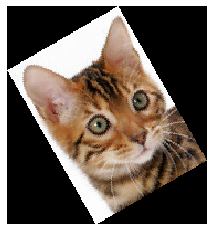

In [28]:
img = np.array(mpimg.imread('part1/cat.jpg'))
img.setflags(write=1)

#TODO
angle = np.radians(30) # rotate anti clockwise by 30 degree
c, s = np.cos(angle), np.sin(angle)
M = np.array(((c, -s, 58), (s, c, 1), (0,0,1))) # your 3x3 matrix
# print(img.shape)

cols = 181
rows = 197 # from output file
cat_crop = img[5:165, 85:200]

cat_sol0_1 = warpPerspective(cat_crop,M,(cols,rows))
plt.axis('off')
plt.imshow(cat_sol0_1)
plt.show()

# 2. Interpolation

At this point, you can predict that creating a large image from small image will not give us the best results, ie there will be a lot of empty pixel values. There are multiple ways to handle this, i.e. Bilinear Interpolation, Nearest, Bicubic etc. However, the method that we will be utilizing in this assignment is fairly simple. We will be replacing empty pixel values with the average of all pixel values around that pixel. Be careful, while handling the corner/side pixels of the image.



## Task 2.1


For this, we can augment your function `warpPerspective(img,M,(cols,rows))`.

1. Where you previously took the nearest neighbor to fill missing pixels, use the `Interpolation` algorithm. 
2. Input cols and rows values as 2000 and 2160
3. Use the same projective matrix
4. Display the output
    
the output should look similar to `part1/cat_sol1.jpg`.

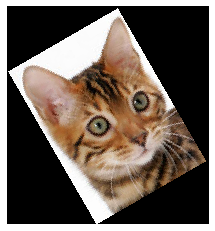

In [26]:
def primeCoord(i, j, M):
  # using this function, I m finding the boundry points of the transfomed image 
  # dividing the new_i and new_j variables by the h value gives the new i and j coordinates in the non-homogenous sstem
    newi, newj, h = np.matmul(M,[i, j, 1])
    newi = newi/h #in float
    newj = newj/h #in float
    return (newi, newj)

#imgr = rows 
#imgc = columns
def bound_check(x_coord, y_coord, imgr, imgc): # compare with the height and width of the image
  if x_coord < 0 or x_coord >= imgr-1 or y_coord < 0 or y_coord >= imgc-1:
    return False
  return True 

def take_average(img,fx,fy,cx,cy,neigh_arr):
  counter = 0
  sum_arr = [0,0,0]

  #the 4 neighbouring points are:
  n1 = (fx, fy)
  n2 = (fx, cy)
  n3 = (cx, fy)
  n4 = (cx, cy)

  #since there are almost 4 points so, my loop runs for at most 4 times to check all the 4 neighbours
  for x in range(4): 
    if neigh_arr[x] != False: # if the neighbouring point is within bound
      if x == 0: # if the current point is point 1, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n1[0]][n1[1]])
        counter = counter +1
      if x == 1: # if the current point is point 2, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n2[0]][n2[1]])
        counter = counter +1
      if x == 2: # if the current point is point 3, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n3[0]][n3[1]])
        counter = counter +1
      if x == 3: # if the current point is point 4, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n4[0]][n4[1]])
        counter = counter + 1

    if counter != 0: # boundary case to check if the counter is not 0
      avg_arr = np.divide(sum_arr, counter) # take the average of the sum of the neighbouring points
      return avg_arr
    else:
      return [0,0,0]

def warpPerspective_new(img,M,dsize):
    col = dsize[0]
    row = dsize[1]

    dst = np.zeros((row, col, 3), dtype=int) # black canvas
    imgr, imgc, x = img.shape
  
    inv_mat = np.linalg.inv(M)

    for i in range(row):
      for j in range (col):
        prime_coord = primeCoord(i, j, inv_mat)
        fx = int(math.floor(prime_coord[0]))
        fy = int(math.floor(prime_coord[1]))
        cx = int(math.ceil(prime_coord[0]))
        cy = int(math.ceil(prime_coord[1]))
        
        #check if the 4 neighbouring points are within bounds
        n1 = bound_check(fx, fy, imgr, imgc)
        n2 = bound_check(fx, cy, imgr, imgc)
        n3 = bound_check(cx, fy, imgr, imgc)
        n4 = bound_check(cx, cy, imgr, imgc)

        neigh_arr = [n1,n2,n3,n4] # this array contains the status(within or not within bounds) of all the neighbouring points
        
        if prime_coord[0] >= 0 and prime_coord[0] < imgr and prime_coord[1] >= 0 and prime_coord[1] < imgc:
          dst[i][j] = take_average(img,fx,fy,cx,cy,neigh_arr)
    
    return dst

#TODO MAIN
img = np.array(mpimg.imread('part1/cat.jpg'))
img.setflags(write=1)

angle = np.radians(30) # rotate anti clockwise by 30 degree
c, s = np.cos(angle), np.sin(angle)
scale = 11 # scale factor

M = np.array(((scale*c, scale*-s, scale*59), (scale*s, scale*c, scale*1), (0,0,1))) # your 3x3 matrix
cols = 2000
rows = 2160
cat_crop = img[5:165, 85:200]

cat_sol1 = warpPerspective_new(cat_crop,M,(cols,rows))
plt.axis('off')
plt.imshow(cat_sol1)
plt.show()

# 3. Image Alpha Values



In this section we will be blending two images to create a third image. This process is important in applications such as VR, AR etc.

For this section, it is important to understand alpha values. Alpha values range between 0.0 and 1.0, and determine the transparency of a pixel. These are common in png files where they are stored alongside rgb as rgba. 

## Task 3.1

You must manipulate your `warpPerspective(img,M,(cols,rows))` function so that it returns values in the form of rgba. You can do this with the following steps: 

1. If the image has values in 8bit integers, convert your 0 - 255 color integer value range to 0.0 - 1.0 float. 
2. Append a forth pixel value for the alpha
3. It might be easier to create a seperate function that converts rgb to rgba with alpha values set to 1.0
4. Where you were previously setting the background to be black, also set the alpha to 0.0
    
The output from the previous test should look similar to `part1/cat_sol2.png`. you can explore the png file structure to get a better idea of the output. 




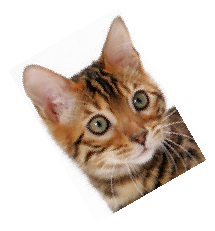

In [25]:
def primeCoord(i, j, M):
  # using this function, I m finding the boundry points of the transfomed image 
  # dividing the new_i and new_j variables by the h value gives the new i and j coordinates in the non-homogenous sstem
    newi, newj, h = np.matmul(M,[i, j, 1])
    newi = newi/h #in float
    newj = newj/h #in float
    return (newi, newj)

#imgr = rows 
#imgc = columns
def bound_check(x_coord, y_coord, imgr, imgc): # compare with the height and width of the image
  if x_coord < 0 or x_coord >= imgr-1 or y_coord < 0 or y_coord >= imgc-1:
    return False
  return True 

def take_average(img,fx,fy,cx,cy,neigh_arr):
  counter = 0
  sum_arr = [0.0, 0.0, 0.0, 0.0]

  #the 4 neighbouring points are:
  n1 = (fx, fy)
  n2 = (fx, cy)
  n3 = (cx, fy)
  n4 = (cx, cy)

  #since there are almost 4 points so, my loop runs for at most 4 times to check all the 4 neighbours
  for x in range(4): 
    if neigh_arr[x] != False: # if the neighbouring point is within bound
      if x == 0: # if the current point is point 1, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n1[0]][n1[1]])
        counter = counter +1
      if x == 1: # if the current point is point 2, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n2[0]][n2[1]])
        counter = counter +1
      if x == 2: # if the current point is point 3, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n3[0]][n3[1]])
        counter = counter +1
      if x == 3: # if the current point is point 4, then add it to the sum and increment the counter
        sum_arr = np.add(sum_arr, img[n4[0]][n4[1]])
        counter = counter + 1

    if counter != 0: # boundary case to check if the counter is not 0
      avg_arr = np.divide(sum_arr, counter) # take the average of the sum of the neighbouring points
      return avg_arr
    else:
      return [0.0,0.0,0.0,0.0]

def warpPerspective_new2(img,M,dsize):
    col = dsize[0]
    row = dsize[1]

    con_fac = (1/255) # this factor is used to convert rgb values to rgba for standardization
    img = (np.array(img))*con_fac

    #we will use np.dstack to stack the rgb values with anadditional axis for the alpha values 
    # for an image we have row(x) and column(y) values, (x,y) so we will stack ones with these 
    # so that the rgba image has a representation as following (x,y,1)

    oned_img = np.ones((img.shape[0], img.shape[1]))
    img2 = np.dstack((img, oned_img)) #this is the new rgba image

    dst = np.zeros((row, col, 4), dtype=float) # black canvas
    imgr, imgc, x = img2.shape
  
    inv_mat = np.linalg.inv(M)

    for i in range(row):
      for j in range (col):
        prime_coord = primeCoord(i, j, inv_mat)
        fx = int(math.floor(prime_coord[0]))
        fy = int(math.floor(prime_coord[1]))
        cx = int(math.ceil(prime_coord[0]))
        cy = int(math.ceil(prime_coord[1]))
        
        #check if the 4 neighbouring points are within bounds
        n1 = bound_check(fx, fy, imgr, imgc)
        n2 = bound_check(fx, cy, imgr, imgc)
        n3 = bound_check(cx, fy, imgr, imgc)
        n4 = bound_check(cx, cy, imgr, imgc)

        neigh_arr = [n1,n2,n3,n4] # this array contains the status(within or not within bounds) of all the neighbouring points
        
        if prime_coord[0] >= 0 and prime_coord[0] < imgr and prime_coord[1] >= 0 and prime_coord[1] < imgc:
          dst[i][j] = take_average(img2,fx,fy,cx,cy,neigh_arr)
    
    return dst

#TODO MAIN
img = np.array(mpimg.imread('part1/cat.jpg'))
img.setflags(write=1)

angle = np.radians(30) # rotate anti clockwise by 30 degree
c, s = np.cos(angle), np.sin(angle)
scale = 11 # scale factor

M = np.array(((scale*c, scale*-s, scale*58), (scale*s, scale*c, scale*1), (0,0,1))) # your 3x3 matrix
cols = 2000
rows = 2160
cat_crop = img[5:165, 85:200]

cat_sol1 = warpPerspective_new2(cat_crop,M,(cols,rows))
plt.axis('off')
plt.imshow(cat_sol1)
plt.show()

# 4. Cricket Stadium

In this part we will be adding an image of a cricket scoreboard to a cricket stadium.



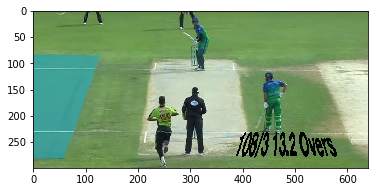

In [24]:
img = np.array(mpimg.imread('stadium-sol5.jpg'))
plt.imshow(img)
plt.show()

## Task 4.1

For this task, you need to transform the given scoreboard image. Your output should look similar to `transformed-scoreboard.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those.

In [0]:
# img = np.array(mpimg.imread('transformed-scoreboard.jpg'))
# img1 = np.array(mpimg.imread('score.jpg'))
# plt.imshow(img1)
# plt.show()
# plt.imshow(img)
# plt.show()

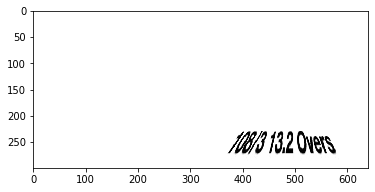

In [23]:
# start your code here
score_img = np.array(mpimg.imread('score.jpg'))
to_transform = np.float32([[0,0], [286,0], [0,45], [286,45]]) #coordinates of the original image(found manually)
transformed = np.float32([[400,220], [560,220], [340,300], [600,300]]) #coordinates of the output image(found manually)

M = cv2.getPerspectiveTransform(to_transform, transformed) #cv2 function to automatically convert hte image 
scoreboard = cv2.warpPerspective(score_img, M, (640,300), borderMode=cv2.BORDER_CONSTANT, borderValue= [255,255,255,255])
plt.imshow(scoreboard)
plt.show()

## Task 4.2

After you have transformed the scorebaord you have to add it to the given stadium image. This can be done by copying pixel values from the transformed scoreboard image to the given stadium image. You need to figure out the appropriate conditions for copying the pixel values. 

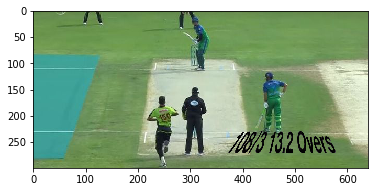

In [20]:
stadium_img = np.array(mpimg.imread('PSL-Stadium.jpg'))
stad_imgr, stad_imgc, h = stadium_img.shape
#print(scoreboard.shape)
#print(stadium_img.shape)
# print(scoreboard[0][0])

for i in range(stad_imgr):
  for j in range(stad_imgc):
    if scoreboard[i][j][0] < 100 and scoreboard[i][j][1] < 100 and scoreboard[i][j][2] < 100:
      stadium_img[i][j] = scoreboard[i][j]
    # print(scoreboard[i][j])

plt.imshow(stadium_img)
plt.show()


## Task 4.3

In certain situations, when we want to isolate a subject in an image, alpha masks are provided to us. Alpha masks describe the transparency of an image. These masks can be in any format ranging from jpg, png, bmp, gif,etc in our example we will be using jpg.

For this part we will reproduce the same solution but by using alpha mask this time. Below you are given an alpha mask for the transfomed scoreboard. Using this alpha mask you need to combine the two images together to produce the same output.

You can achieve the desired solution as follows:

Consider the transformed scoreboard image as the foreground image and the stadium image as the background image. At every pixel of the image, we need to combine the foreground image pixel value with the background image pixel value using the alpha mask.

 
\begin{align*}
T = \alpha*F+(1-\alpha)B
\end{align*}

1. Where T is target pixel value
2. F is the pixel value in the foreground image
3. B is the pixel value of the background image
4. Alpha is value of the alpha mask for the corresponding pixels

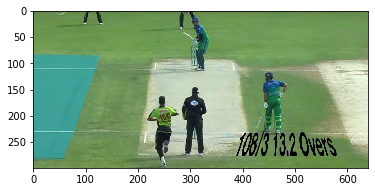

In [19]:
def jpgtopng(i, j, img): # convert a jpg image to png
  con_fac = 1/255 # this is the convertion factor used to convert a jpg image to png
  r = (img[i][j][0])*con_fac
  g = (img[i][j][1])*con_fac
  b = (img[i][j][2])*con_fac
  a = 1

  return np.array([r,g,b,a])

# start your code here
stadium = np.array(mpimg.imread('PSL-Stadium.jpg'))
tscoreboard = np.array(mpimg.imread('tscoreboard.jpg'))
score_mask = np.array(mpimg.imread('score_mask.jpg'))
# plt.imshow(stadium)
# plt.imshow(tscoreboard)
# plt.imshow(score_mask)

trans_imgr, trans_imgc, h = score_mask.shape
png_scoreboard = np.zeros((trans_imgr, trans_imgc, 4), dtype=float) # a temp black canvas to get new transformed scroeboard image
# print(trans_imgr, trans_imgc)

for i in range(trans_imgr):
  for j in range(trans_imgc):
    if score_mask[i][j][0] >= 100 and score_mask[i][j][1] >= 100 and score_mask[i][j][2] >= 100: #if the color of the mask is not close to black then copy the score (in black) from the transfomed image to the new made canvas
      # png_scoreboard[i][j] = np.array([0,0,0,0])
      #convert the jpg image to png s(rgb to rgba)
      # r = (tscoreboard[i][j][0])*con_fac
      # g = (tscoreboard[i][j][1])*con_fac
      # b = (tscoreboard[i][j][2])*con_fac
      # a = 1 # we know that alpha value is 1
      # #print(r,g,b,a)
      # png_scoreboard[i][j] = np.array([r,g,b,a])
      png_scoreboard[i][j] = jpgtopng(i,j,tscoreboard)
    
stad_imgr, stad_imgc, h_stad = stadium.shape
png_stadium = np.zeros((stad_imgr, stad_imgc, 4),  dtype=float)

# convert the stadium image to png
for x in range(stad_imgr):
  for y in range(stad_imgc):
    png_stadium[x][y] = jpgtopng(x,y,stadium)

#F = foreground image is the temp_canvas
#B = background image is the png_stadium
#α = F[3] in each pixel
#T = α∗F+(1−α)B 
result = np.zeros((stad_imgr, stad_imgc, 4), dtype=float)

# use the png_stadium and png_scoreboard to give the final output based on the given formula
for a in range(stad_imgr):
  for b in range(stad_imgc):
    F = png_scoreboard[a][b]
    B = png_stadium[a][b]
    alp = F[3]
    T = (alp*F) + ((1-alp)*B)

    result[a][b] = T

plt.imshow(result)

# 5. Solar System (CS5310, EE513 Only, Upto 10 marks bonus for CS436)

![alt Solar System demo](https://drive.google.com/uc?id=10xxjq46hha2HS0xjyaqM-iwgrMg01d6w)

In [0]:
height = width = 1500 # shape of canvas

## Task 5.1
In this task you will try to recreate the above gif by making use of all the previously implemented techniques.

Your first task is to import the image of planet earth and apply appropriate transformations to center it within the canvas. 

You are allowed to import opencv and make use of cv2.warpPerspective(sun,M,(width, height)) 



345 365


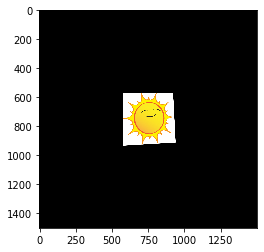

In [66]:
# Import sun.jpg and apply appropriate transformations to center the image
sun = np.array(mpimg.imread('sun.jpg'))
sunr, sunc, h = (sun.shape)
print(sunr,sunc)
sun_coord = np.array([[0,0], [0,sunr-1], [sunc-1,0], [sunr-1,sunc-1]], np.float32) #mnaullay find the coordinates of the original sun image
new_sun_coord = np.array([[577,568], [577,933], [922,568], [922,933]], np.float32) #mnaullay find the center coordinates for the transformed sun image

rows = 1500
col = 1500

new_canvas = np.zeros((rows, col, 3)) # white canvas
M = cv2.getPerspectiveTransform(sun_coord, new_sun_coord)
sun_center = cv2.warpPerspective(sun, M, (rows,col))

plt.imshow(sun_center)

Your result should look like (It does not matter whether the background is black or white)

Note: The resulting canvas has height and width of 1500px

![alt Sun Result](https://drive.google.com/uc?id=1IdYgql7RFwvXT1SxwuBRkW3AMKdZeexg)

## Task 5.2
In this part, you will carry out the same process for earth.jpg as well. Except, in this case the earth needs to be translated +400px on the y axis.

345 365


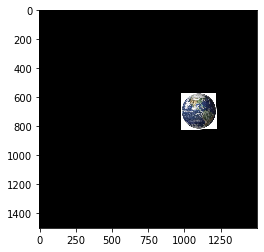

In [70]:
# Import sun.jpg and apply appropriate transformations to center the image
earth = np.array(mpimg.imread('earth.jpg'))
earthr, earthc, h = (sun.shape)
print(sunr,sunc)
earth_coord = np.array([[0,0], [0,sunr], [sunc,0], [sunr,sunc]], np.float32) #mnaullay find the coordinates of the original sun image
new_earth_coord = np.array([[577+400,568], [577+400,933], [922+400,568], [922+400,933]], np.float32) #mnaullay find the center coordinates for the transformed sun image

rows = 1500
col = 1500

new_canvas = np.zeros((rows, col, 3)) # white canvas
M = cv2.getPerspectiveTransform(earth_coord, new_earth_coord)
# print(M)
# print(M[0][2])
earth_center = cv2.warpPerspective(earth, M, (rows,col))

plt.imshow(earth_center)

Your final image should look something like this

![alt Result earth](https://drive.google.com/uc?id=16eFaOHVlhUKgHpw8ZVCwSvzagJcD_s8K)

## Task 5.3
You will now modify the above code to apply rotations to the earth as such it rotates along its own axis as well as around the sun. (This is same as the problem given to you in your written assignment 1)

Feel free to copy your code from task 5.2

In [0]:
earth_func(earth,hour):
  #earth -> this is the imported earth.jpg file in numpy array format
  #hour -> You will use this parameter to caculate the rotation of earth around the sun and along its own axis. For example,
  # if hour == 15 then rotation on its own axis will be 225 deg whilst rotations around the sun will be 0.61 deg
  # return val will be the transformed image of earth such as if hours == 0 the resulting image will be the same as task 5.2
  return earth_

SyntaxError: invalid syntax (<ipython-input-14-394bdbd1f645>, line 1)

In [0]:
earths = []
for x in range(30):
  earths.append(earth_func(earth,x*10))

NameError: name 'earth_func' is not defined

## Task 5.4
You will now blend all three images to compose a single image. Feel free to make use of the canvas below.

You will have to traverse every element of the list (earths) and blend them with the transformed sun image created in task 5.1. After doing this, you will get an array of images in the end with each having a sun and a earth in them. Store this array in the variable final and run the code gif builder code in the end

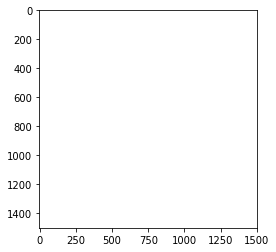

In [0]:
# Code for canvas
canvas = np.array([255]*3*width*height)
canvas.resize((width,height,3))
plt.imshow(canvas)

In [0]:
# gif builder code
# final is a list of numpy images 
imageio.mimsave('movie.gif', final)

Please submit movie.gif along with the jupyter notebook

# Submission Instructions

You are required to submit the CV_PA1 Jupyter file and Part-5 gif only via LMS. Rename CV_PA1 to CV_PA1_[your rollnumber]. 

The submitted file should be in a readable and understandable format. Add as many comments as possible. It should run from start to end without any errors. It must be in Python3.

The notebook "CV_PA1_intro" will help you get started with image manipulation. If you are familiar with it, skip it.
